In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib
from scipy import stats, optimize

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue.dynamics.planar_gradients import area_grad
from tyssue_taylor.adjusters.adjust_annular import (prepare_tensions, adjust_tensions,
                                                    adjust_areas, adjust_scale, adjust_parameters)
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model, lumen_area_grad
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces, _coef_matrix, _right_side
from tyssue_taylor.models.display import (create_organo, print_tensions, rendering_results,
                                          rendering_convergence_results,
                                          plot_force_inference)

Error: IPOPT shared library failed to import


Using TensorFlow backend.


In [2]:
nf, r_in, r_out = (3, 1, 4)
organo = create_organo(nf, r_in, r_out, rot=np.pi/12)

organo.edge_df.loc[:nf, 'line_tension'] *= 2
organo.edge_df.loc[nf:2*nf-1, 'line_tension'] = 0
geom.update_all(organo)
Solver.find_energy_min(organo, geom, model)

Reseting datasets values with new specs


      fun: 0.0039027516547474467
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.73810387e-04,  5.19462119e-04,  2.97653285e-05,  3.78231271e-04,
        1.68010260e-04, -1.89377502e-04, -7.33005113e-05, -3.35109636e-04,
       -2.82689092e-04, -2.90201539e-04, -1.09820151e-04, -8.02681331e-05])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 3
   status: 0
  success: True
        x: array([ 0.1856511 , -0.1713566 , -0.25408152, -0.06562345,  0.06783918,
        0.23669497,  0.79912887, -0.74215143, -1.09073003, -0.2833752 ,
        0.29217879,  1.02580029])

In [3]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-5,'ftol': 1e-3, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-5,'ftol': 1e-3, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', #'callback': printx,
            'output_path': './PSQP_areas.out'}
nm_opt = {'method':'Nelder-Mead', 'options': {'disp': True}}

reg_weight = 1e-3
theta = 0.02

Force inference with tensions and pressions solved with NNLS

Solving time: 0.28815800000000014
Distance from th organo to exp organo : 2.3385611469248517
Distance from th tensions to exp tensions : 0.0030078864074188968


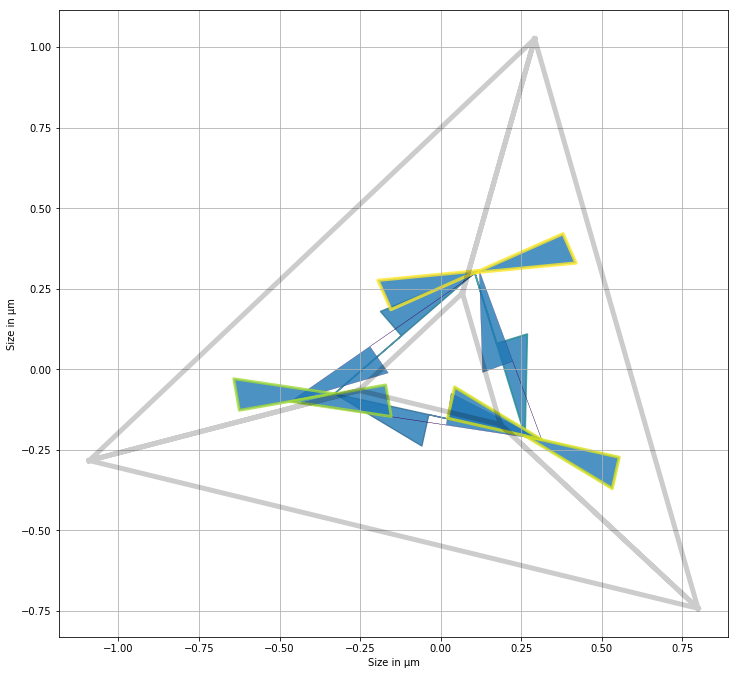

In [4]:
nb_cells = organo.Nf
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
areas_organo = organo.copy()
areas_organo.edge_df.line_tension = prepare_tensions(areas_organo,
                                                            initial_guess['tensions'])
areas_organo.face_df.prefered_area = initial_guess['areas'][:-1]
areas_organo.settings['prefered_lumen_vol'] = initial_guess['areas'][-1]
#print('Energy before optimization: ', model.compute_energy(areas_organo, False))
Solver.find_energy_min(areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
#print('Energy after optimization: ', model.compute_energy(areas_organo, False))
print_tensions(areas_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, areas_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] - initial_guess['tensions']))))

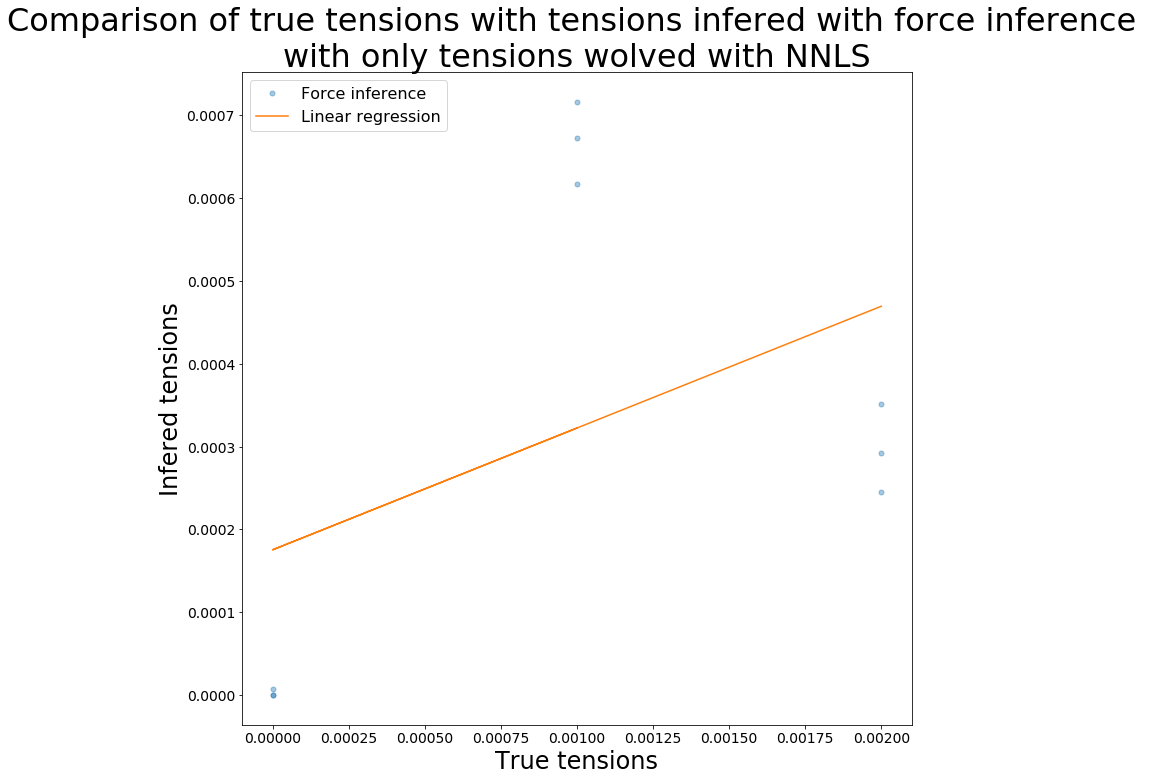

R value : 0.4370861300952515 
Standard error : 0.00021389142896271066


In [5]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  initial_guess['tensions'],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

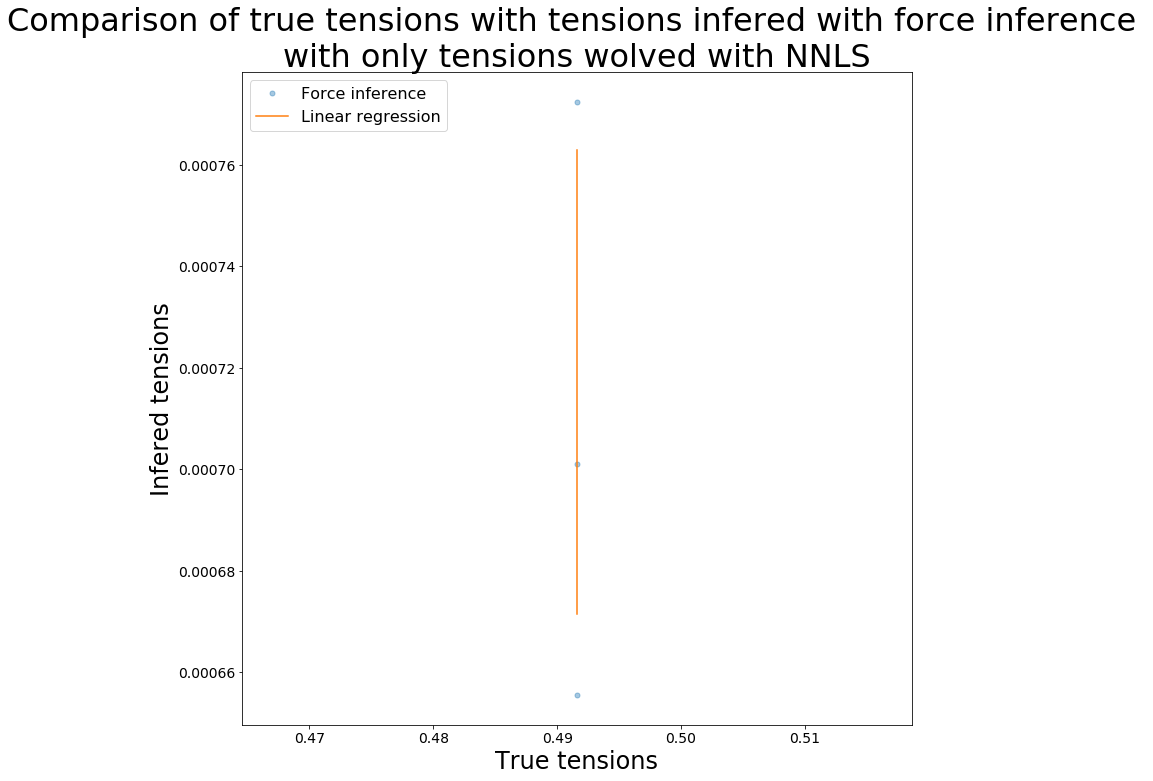

R value : -0.98922287734167 
Standard error : 5.346610469700506e-06


In [6]:
rendering_results(organo, organo.face_df.prefered_area,
                  initial_guess['areas'][:-1],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Scale factor optimization

iter   time      nfev    incumbent   f(incumbent)
   1    2.32      10      0.00000     0.00556
   2    3.39      15      0.00000     0.00556
   3    3.76      20      0.04000     0.00553
   4    4.50      30      0.04400     0.00553
Brut force search summary
              solving time: 4.4971230030059814
              nb iter: 4
              nfev: 30
              x_ub: 0.04400000000000001
              ub: 0.005527125151452662
Optimization terminated successfully.
         Current function value: 0.005487
         Iterations: 17
         Function evaluations: 34
Solving time: 9.587354999999999


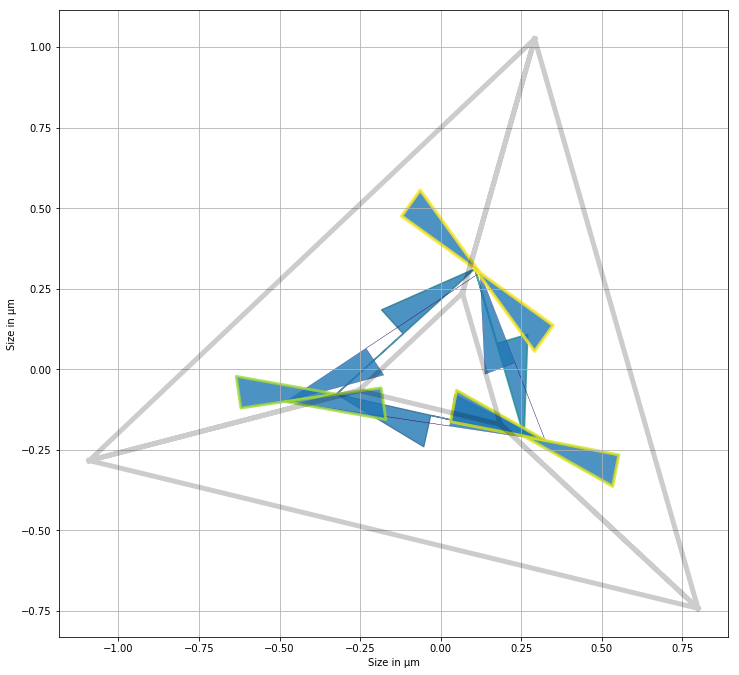

In [7]:
initial_guess = infer_forces(organo, 'NNLS', sup_param='areas')
start = time.clock()
rescaled_areas_organo = organo.copy()
opt_scale = adjust_scale(organo,
                         initial_guess['tensions'],
                         verbose=2,
                         **nm_opt)
rescaled_areas_organo.edge_df.line_tension = prepare_tensions(rescaled_areas_organo,
                                                                     opt_scale.x*initial_guess['tensions'])
rescaled_areas_organo.face_df.prefered_area = initial_guess['areas'][:-1]
rescaled_areas_organo.settings['prefered_lumen_vol'] = initial_guess['areas'][-1]
Solver.find_energy_min(rescaled_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(rescaled_areas_organo, organo)

In [8]:
dist_init_point = np.sum(np.linalg.norm(_distance(areas_organo, rescaled_areas_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(organo, rescaled_areas_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             areas_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         rescaled_areas_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at optima : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 0.05420795154733604
Distance from th organo to exp organo at optima: 2.3226251319517814
Distance from th tensions to exp tensions at initial point : 0.0030078864074188968
Distance from th tensions to exp tensions at optima : 0.003783864446848343


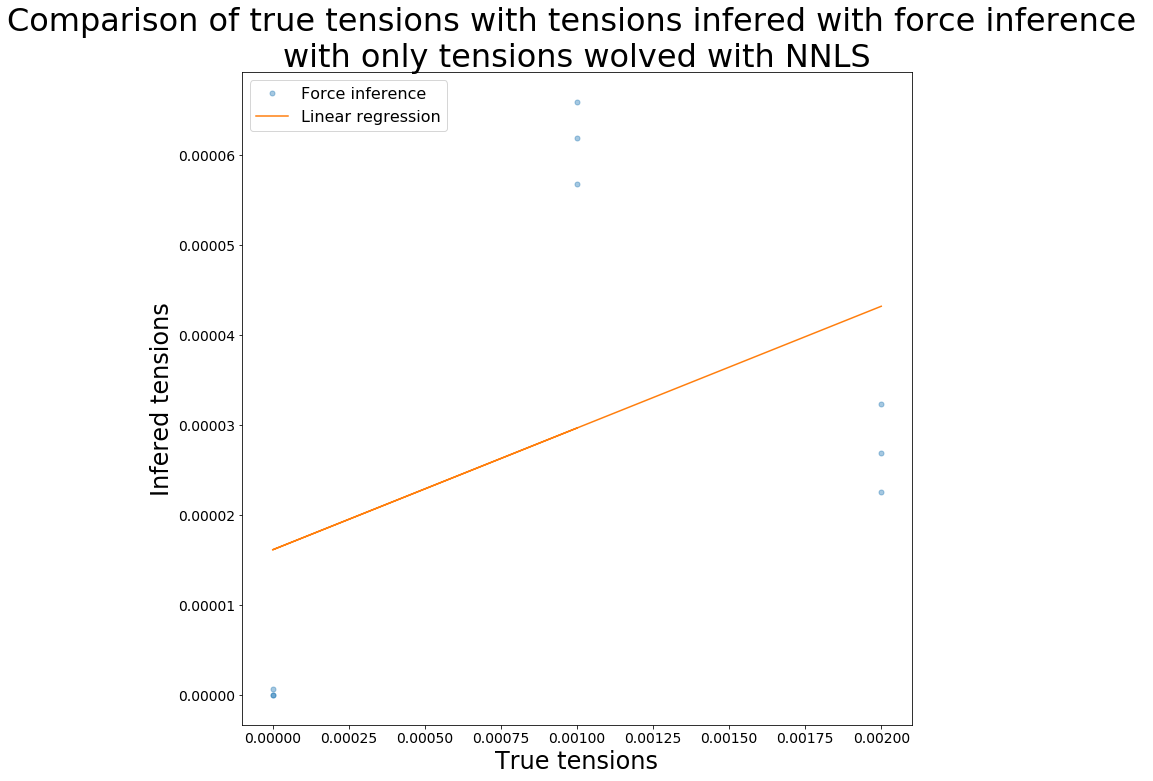

R value : 0.4370861300952515 
Standard error : 1.9675337821707325e-05


In [9]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  rescaled_areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

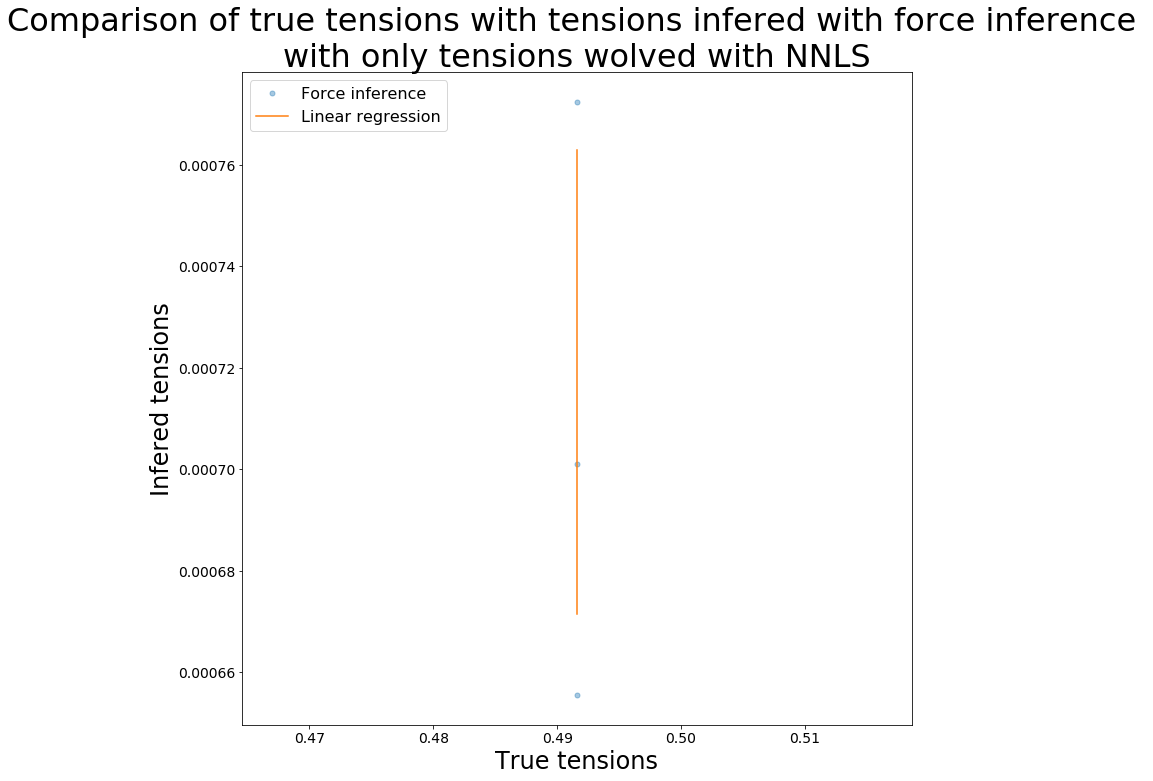

R value : -0.98922287734167 
Standard error : 5.346610469700506e-06


In [10]:
rendering_results(organo, organo.face_df.prefered_area,
                  rescaled_areas_organo.face_df.prefered_area,
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

Distance minimization

`xtol` termination condition is satisfied.
Function evaluations 100, initial cost 2.5807e-06, final cost 6.1838e-21, first-order optimality 7.76e-16.
Solving time: 17.471685
Distance from th organo to exp organo : 2.3372104732977084
Distance from th tensions to exp tensions : 0.002478554296153514


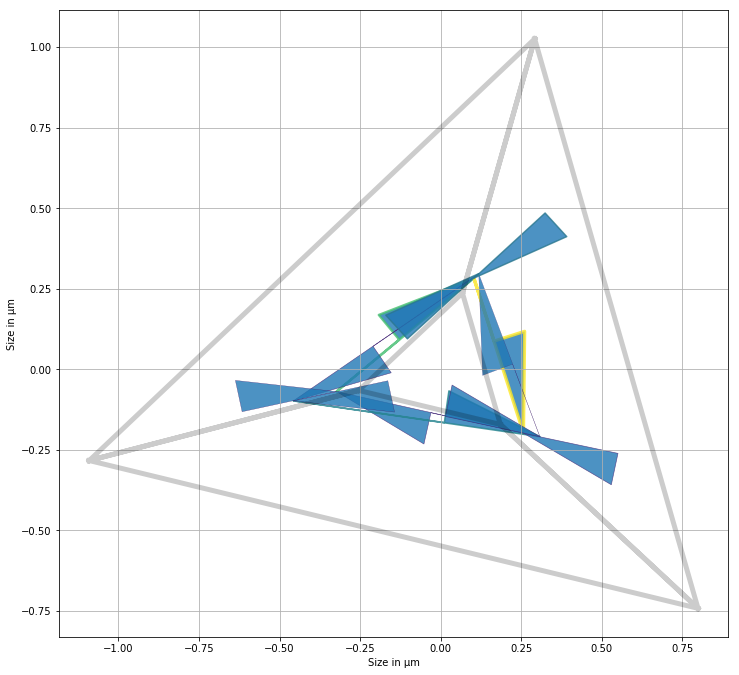

In [11]:
iprint_file = "../../assets/dist_at_each_f_ev/30_01_areas.txt"
res_sym_tensions = adjust_tensions(organo, opt_scale.x*initial_guess['tensions'], 
                                   {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                   energy_opt, iprint_file=iprint_file, **lm_opt)
opt_areas_organo = organo.copy()
opt_areas_organo.edge_df.line_tension = prepare_tensions(opt_areas_organo, res_sym_tensions.x)
opt_areas_organo.face_df.prefered_area = initial_guess['areas'][:-1]
opt_areas_organo.settings['prefered_lumen_vol'] = initial_guess['areas'][-1]
Solver.find_energy_min(opt_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_areas_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_areas_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                opt_areas_organo.edge_df.line_tension[:3*nb_cells]))))

In [12]:
dist_init_point = np.sum(np.linalg.norm(_distance(rescaled_areas_organo, opt_areas_organo), axis=1))
dist_optima = np.sum(np.linalg.norm(_distance(opt_areas_organo, opt_areas_organo), axis=1))
tens_diff_init_point = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                             rescaled_areas_organo.edge_df.line_tension[:3*nb_cells]))
tens_diff_optima = np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                         opt_areas_organo.edge_df.line_tension[:3*nb_cells]))
print('Distance from th organo to exp organo at initial point : ' + str(dist_init_point))
print('Distance from th organo to exp organo at optima: ' + str(dist_optima))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_init_point))
print('Distance from th tensions to exp tensions at initial point : ' + str(tens_diff_optima))

Distance from th organo to exp organo at initial point : 0.09640935020845934
Distance from th organo to exp organo at optima: 0.0
Distance from th tensions to exp tensions at initial point : 0.003783864446848343
Distance from th tensions to exp tensions at initial point : 0.002478554296153514


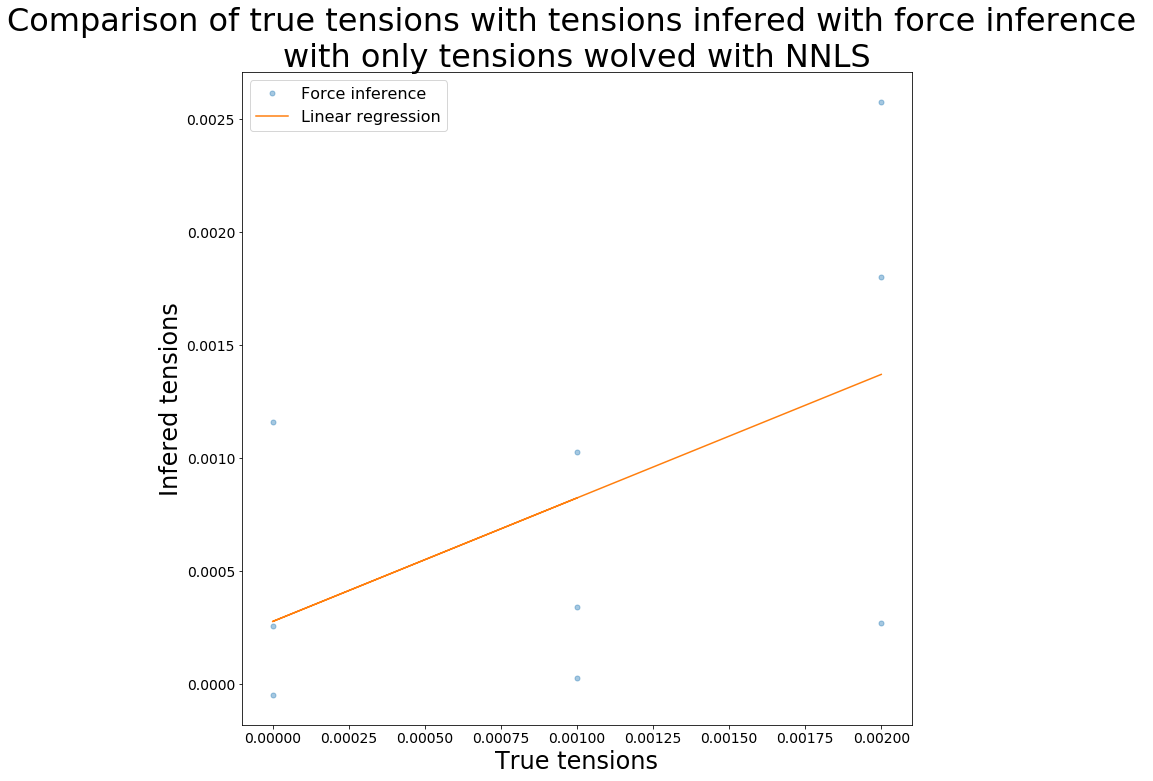

R value : 0.5281653799444793 
Standard error : 0.0006210105908414171


In [13]:
rendering_results(organo, organo.edge_df.line_tension[:3*organo.Nf],
                  opt_areas_organo.edge_df.line_tension[:3*organo.Nf],
                  'Comparison of true tensions with tensions infered with force inference \n' +
                  'with only tensions wolved with NNLS',
                  'True tensions', 'Infered tensions', ('Force inference', 'Linear regression'))

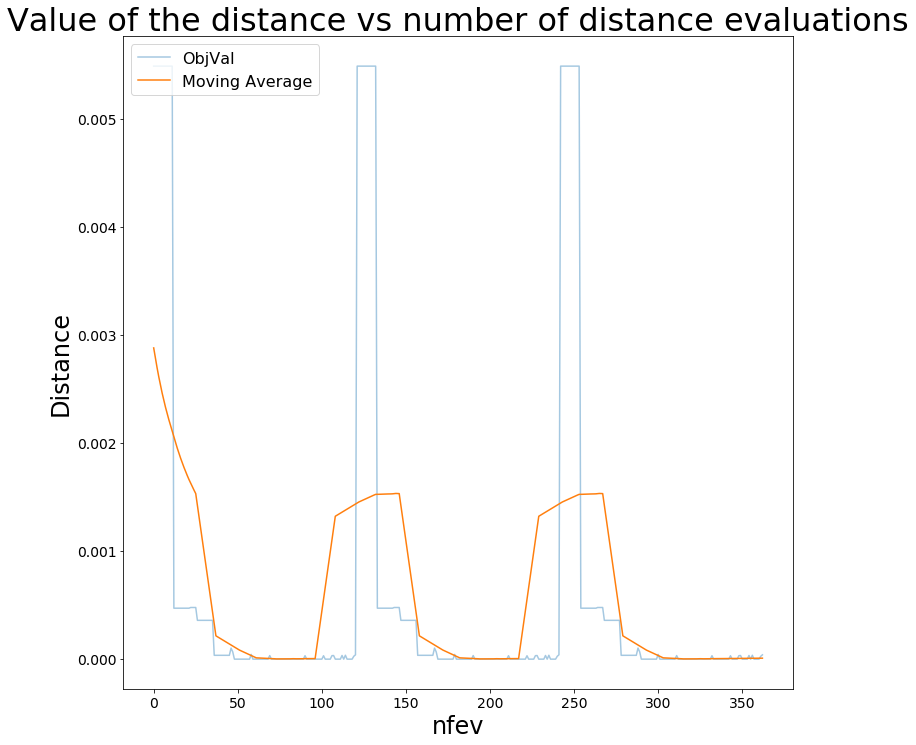

In [14]:
iter_data = pd.read_csv(iprint_file, header=None)
rendering_convergence_results(np.arange(len(iter_data[0])),
                              iter_data[0],
                              'Value of the distance vs number of distance evaluations',
                              'nfev', 'Distance', ('ObjVal', 'Moving Average'),
                              data_dot='-', rol_win=50)

In [15]:
iprint_file = "../../assets/dist_at_each_f_ev/30_01_areas.txt"
initialization = np.concatenate((opt_scale.x*initial_guess['tensions'],
                                 organo.face_df.prefered_area,
                                 [organo.settings['prefered_lumen_vol']]))
res_sym_tensions = adjust_parameters(organo, opt_scale.x*initial_guess['tensions'], 
                                     {'dic':{'apical' : False, 'basal': False}, 'weight':0},
                                     energy_opt, iprint_file=iprint_file, **lm_opt)
opt_areas_organo = organo.copy()
opt_areas_organo.edge_df.line_tension = prepare_tensions(opt_areas_organo, res_sym_tensions.x)
Solver.find_energy_min(opt_areas_organo, geom, model)
print('Solving time: '+str(time.clock()-start))
print_tensions(opt_areas_organo, organo)
print('Distance from th organo to exp organo : ' +
      str(np.sum(np.linalg.norm(_distance(organo, opt_areas_organo), axis=1))))
print('Distance from th tensions to exp tensions : ' +
      str(np.sum(np.linalg.norm(organo.edge_df.line_tension[:3*nb_cells] -
                                opt_areas_organo.edge_df.line_tension[:3*nb_cells]))))

{'method': 'lm', 'xtol': 1e-05, 'ftol': 0.001, 'verbose': 1}
I know I do LM


ValueError: too many values to unpack (expected 2)

In [ ]:
np.cumsum([organo.datasets[elem][column].size for elem, column in [('edge', 'line_tension'),
                                  ('face', 'prefered_area')]])